In [ ]:
pip install --upgrade seaborn statsmodels patsy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
pip install nba_api

In [ ]:
from nba_api.stats.endpoints import leaguegamelog
import time
from nba_api.stats.endpoints import leaguedashteamstats

In [ ]:
# 'parse_dates' loads dates correctly instantly
df = pd.read_csv('games.csv', parse_dates=['GAME_DATE_EST'])

# Sort chronologically to prevent leakage
df = df.sort_values('GAME_DATE_EST')

# Keep only Seasons 2015 to 2022
df = df[(df['SEASON'] >= 2015) & (df['SEASON'] <= 2022)]

# Reset the index so row 0 is actually the first game of 2015
df = df.reset_index(drop=True)

In [ ]:
print(df.head())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2015-10-02  11500001            Final    1610612746       1610612743   
1    2015-10-03  11500003            Final    1610612754       1610612740   
2    2015-10-03  11500002            Final    1610612753       1610612766   
3    2015-10-04  11500004            Final    1610612747       1610612762   
4    2015-10-04  11500005            Final    1610612761       1610612746   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2015    1610612746     103.0        0.407        0.769  ...      22.0   
1    2015    1610612754     105.0        0.413        0.613  ...      21.0   
2    2015    1610612753     100.0        0.438        0.842  ...      22.0   
3    2015    1610612747      71.0        0.289        0.619  ...      11.0   
4    2015    1610612761      93.0        0.425        0.806  ...      11.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_P

# **Adding API Data and Splitting (Home/Away)**

In [ ]:
# Filter for regular season games only
df['GAME_ID'] = df['GAME_ID'].astype(str)
df = df[df['GAME_ID'].str.startswith('2')].copy()

df['GAME_ID'] = df['GAME_ID'].astype(int)

# Get unique seasons
unique_seasons = df['SEASON'].unique()
api_logs = []

for season in unique_seasons:
    # We take the last 2 digits of the next year
    next_year = str(season + 1)[-2:]
    season_str = f"{season}-{next_year}"
    log = leaguegamelog.LeagueGameLog(season=season_str, season_type_all_star='Regular Season', player_or_team_abbreviation='T')
    # Add to list
    game_data = log.get_data_frames()[0]
    api_logs.append(game_data)

    # Prevent rate limit
    time.sleep(0.6)

# Stack all the API data into one table
df_api = pd.concat(api_logs)

# Ensure GAME_ID is a int so it matches
df['GAME_ID'] = df['GAME_ID'].astype(int)
df_api['GAME_ID'] = df_api['GAME_ID'].astype(int)

cols_to_keep = ['GAME_ID', 'TEAM_ID', 'STL', 'BLK', 'DREB', 'TOV']
df_api_slim = df_api[cols_to_keep].copy()

# Merge home stats
df = pd.merge(df, df_api_slim, left_on=['GAME_ID', 'HOME_TEAM_ID'], right_on=['GAME_ID', 'TEAM_ID'], how='left')
# Rename
df = df.rename(columns={'STL': 'STL_home', 'BLK': 'BLK_home', 'DREB': 'DREB_home', 'TOV': 'TOV_home', 'PF': 'PF_home'})
# Drop the extra column
df = df.drop(columns=['TEAM_ID'])

# Merge away stats
df = pd.merge(df, df_api_slim, left_on=['GAME_ID', 'VISITOR_TEAM_ID'], right_on=['GAME_ID', 'TEAM_ID'], how='left')
# Rename
df = df.rename(columns={'STL': 'STL_away', 'BLK': 'BLK_away', 'DREB': 'DREB_away', 'TOV': 'TOV_away', 'PF': 'PF_away'})
# Drop the extra column
df = df.drop(columns=['TEAM_ID'])

# Fill missing data
df = df.fillna(0)

# Duplicates otherwise when running multiple times in Colab
df = df.loc[:, ~df.columns.duplicated(keep='last')]

# **Define Stats, Calculate Differentials, Merge DataFrames**

In [ ]:

# Define stats
stats_cols = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'STL', 'BLK', 'DREB', 'TOV']

# Home
# Need season for last season's winrate calc
home_cols = ['GAME_DATE_EST', 'HOME_TEAM_ID', 'HOME_TEAM_WINS', 'SEASON']
for col in stats_cols:
    home_cols.append(col + '_home')

df_home = df[home_cols].copy()
# Rename
new_names = ['Date', 'Team_ID', 'Won', 'SEASON'] + stats_cols
df_home.columns = new_names

# Away
away_cols = ['GAME_DATE_EST', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS', 'SEASON']
for col in stats_cols:
    away_cols.append(col + '_away')

df_away = df[away_cols].copy()
df_away.columns = new_names
# Inverse the won column because home losing is away winning
df_away['Won'] = 1 - df_away['Won']

# Stack with df_rolling
df_rolling = pd.concat([df_home, df_away])
df_rolling = df_rolling.sort_values('Date')

# Add last year's winrate
season_wins = df.groupby(['SEASON', 'HOME_TEAM_ID'])['HOME_TEAM_WINS'].mean().reset_index()
season_wins['SEASON'] = season_wins['SEASON'] + 1 # Shift year forward
season_wins.columns = ['SEASON', 'Team_ID', 'Prior_Win_Rate']

# Merge into df_rolling
df_rolling = pd.merge(df_rolling, season_wins, on=['SEASON', 'Team_ID'], how='left')
df_rolling['Prior_Win_Rate'] = df_rolling['Prior_Win_Rate'].fillna(0.50)

In [ ]:
# Calculate the rolling stats

team_frames = []
unique_teams = df_rolling['Team_ID'].unique()


for team in unique_teams:
    team_df = df_rolling[df_rolling['Team_ID'] == team].copy()
    # Calculate days since last game
    # Subtract 1 because if you played yesterday you have 0 days of rest
    team_df['Rest_Days'] = team_df['Date'].diff().dt.days - 1

    # Fill the first game of the season with 7 days
    team_df['Rest_Days'] = team_df['Rest_Days'].fillna(7)

    # Cap rest days at 7
    team_df['Rest_Days'] = team_df['Rest_Days'].clip(lower=0, upper=7)

    # Create a counter for the game number
    team_df['Game_Number'] = range(1, len(team_df) + 1)

    for col in stats_cols:
        # Average
        team_df['Avg_' + col] = team_df[col].expanding().mean().shift(1)

        # SD
        team_df['Std_' + col] = team_df[col].expanding().std().shift(1)

    # WR and momentum (last 10)
    team_df['Win_Rate'] = team_df['Won'].expanding().mean().shift(1)
    # Set min periods to use what's there (if less than 10)
    team_df['Last_10'] = team_df['Won'].rolling(window=10, min_periods=1).mean().shift(1)
    team_frames.append(team_df)

df_rolling = pd.concat(team_frames).dropna()

# Drop season
if 'SEASON' in df_rolling.columns:
    df_rolling = df_rolling.drop(columns=['SEASON'])

# Columns to keep during the merge
cols_to_merge = ['Rest_Days', 'Game_Number']
for col in df_rolling.columns:
    if col not in ['Date', 'Team_ID', 'Won', 'SEASON', 'Rest_Days', 'Game_Number'] + stats_cols:
        cols_to_merge.append(col)

# Merge Home
df_final = pd.merge(df, df_rolling, left_on=['GAME_DATE_EST', 'HOME_TEAM_ID'], right_on=['Date', 'Team_ID'])

rename_map_home = {}
for col in cols_to_merge:
    rename_map_home[col] = col + '_Home'
df_final = df_final.rename(columns=rename_map_home)

# Drop what's not needed
drop_cols = ['Date', 'Team_ID', 'Won', 'SEASON'] + stats_cols
df_final = df_final.drop(columns=drop_cols, errors='ignore')

# Merge Away
df_final = pd.merge(df_final, df_rolling, left_on=['GAME_DATE_EST', 'VISITOR_TEAM_ID'], right_on=['Date', 'Team_ID'])

rename_map_away = {}
for col in cols_to_merge:
    rename_map_away[col] = col + '_Away'
df_final = df_final.rename(columns=rename_map_away)

df_final = df_final.drop(columns=drop_cols, errors='ignore')

# Loops to calculate the differentials between the two 2 teams

for col in stats_cols:
    # Avg diff
    home_col = 'Avg_' + col + '_Home'
    away_col = 'Avg_' + col + '_Away'
    df_final['Diff_Avg_' + col] = df_final[home_col] - df_final[away_col]

    # Std diff
    home_std = 'Std_' + col + '_Home'
    away_std = 'Std_' + col + '_Away'
    df_final['Diff_Std_' + col] = df_final[home_std] - df_final[away_std]

# WR and momentum differential
df_final['Diff_Win_Rate'] = df_final['Win_Rate_Home'] - df_final['Win_Rate_Away']
df_final['Diff_Last_10'] = df_final['Last_10_Home'] - df_final['Last_10_Away']

# Last season WR differential
df_final['Diff_Prior_Win_Rate'] = df_final['Prior_Win_Rate_Home'] - df_final['Prior_Win_Rate_Away']

# Rest days differential
df_final['Diff_Rest_Days'] = df_final['Rest_Days_Home'] - df_final['Rest_Days_Away']

# Game number differential
df_final['Diff_Game_Number'] = df_final['Game_Number_Home'] - df_final['Game_Number_Away']

In [ ]:
# Only need date, home team wins, and our feature columns (the differentials)
keep_cols = ['GAME_DATE_EST', 'HOME_TEAM_WINS', 'Game_Number_Home'] + [col for col in df_final.columns if 'Diff_' in col]

# Creating a streamlined df for our model
df_model = df_final[keep_cols].copy()

print(df_model.tail())

     GAME_DATE_EST  HOME_TEAM_WINS  Game_Number_Home  Diff_Avg_PTS  \
8933    2022-12-21               0               589      1.650749   
8934    2022-12-21               0               585      2.879853   
8935    2022-12-21               1               587      3.520812   
8936    2022-12-22               1               591     -2.084801   
8937    2022-12-22               1               588      1.965151   

      Diff_Std_PTS  Diff_Avg_FG_PCT  Diff_Std_FG_PCT  Diff_Avg_FT_PCT  \
8933     -0.054182        -0.008934        -0.000987         0.019673   
8934      0.625587         0.001821        -0.001645        -0.003980   
8935      0.426085         0.015868         0.002869         0.023402   
8936      0.751821        -0.002690         0.001995        -0.005533   
8937     -0.037258        -0.003883        -0.000658        -0.031152   

      Diff_Std_FT_PCT  Diff_Avg_FG3_PCT  ...  Diff_Std_BLK  Diff_Avg_DREB  \
8933        -0.003722          0.001059  ...     -0.018071     

# **Models and Data Split**

In [ ]:
# Sort by date so only past data is used to predict future games
df_model = df_model.sort_values('GAME_DATE_EST')

# Instead of 0, fill missing shooting percentages with league averages (approximate)
fill_values = {
    'Avg_PTS_Home': 114, 'Avg_PTS_Away': 112,
    'Avg_FG_PCT_Home': 0.48, 'Avg_FG_PCT_Away': 0.46,
    'Avg_FG3_PCT_Home': 0.36, 'Avg_FG3_PCT_Away': 0.35,
    'Last_10_Home': 0.52, 'Last_10_Away': 0.48  # Start with 50% win rate momentum
}
df_model = df_model.fillna(value=fill_values)
# Then fill any remaining NaNs (like standard deviation) with 0
df_model = df_model.fillna(0)

# Define X and y and drop the date along with the wins
X = df_model.drop(columns=['GAME_DATE_EST', 'HOME_TEAM_WINS'])
y = df_model['HOME_TEAM_WINS']


# Train on the first 80% of games (past) and test on the last 20% of games (future)
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Training on " + str(len(X_train)) + " games.")
print("Testing on " + str(len(X_test)) + " games.")

Training on 7150 games.
Testing on 1788 games.


In [ ]:

# Scale everything
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Define the grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# We use max_iter=1000 to prevent "ConvergenceWarning" errors
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)

# Best results
best_lr = grid_lr.best_estimator_

print("Best Settings: " + str(grid_lr.best_params_))

acc_score = best_lr.score(X_test_scaled, y_test)
print("Test Set Accuracy: " + str(round(acc_score * 100, 1)) + "%")

# Top coefficients
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lr.coef_[0]
})

# Sort by the most positive impact
coefs = coefs.sort_values('Coefficient', ascending=False)

print("\nTop 5 Drivers of Winning (LR):")
print(coefs.head(5))

Best Settings: {'C': 0.001}
Test Set Accuracy: 62.6%

Top 5 Drivers of Winning (LR):
                Feature  Coefficient
22         Diff_Last_10     0.239738
23  Diff_Prior_Win_Rate     0.115650
21        Diff_Win_Rate     0.110394
3       Diff_Avg_FG_PCT     0.062052
18        Diff_Std_DREB     0.056851


In [ ]:
# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Grid
param_grid_knn = {
    'n_neighbors': [5, 10, 15, 20, 30, 50],   # Similar games to check
    'weights': ['uniform', 'distance'],       # How to treat the neighbors
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_scaled, y_train)

# Best model
best_knn = grid_knn.best_estimator_

print("Best Settings: " + str(grid_knn.best_params_))

acc_score = best_knn.score(X_test_scaled, y_test)
print("Test Set Accuracy: " + str(round(acc_score * 100, 1)) + "%")

Best Settings: {'n_neighbors': 50, 'weights': 'distance'}
Test Set Accuracy: 58.8%


In [ ]:
# Setting params
param_grid_xgb = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],   # How much each tree contributes
    'max_depth': [3, 5, 7],              # How complex each tree is
    'subsample': [0.8, 1.0]              # Use only 80% of data per tree
}

# Run grid
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                        param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)

grid_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_xgb.best_estimator_
print("Best Settings: " + str(grid_xgb.best_params_))

# Calculate accuracy score
acc_score = best_xgb.score(X_test, y_test)
print("Test Accuracy: " + str(round(acc_score * 100, 1)) + "%")

# Feature importance
importances_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 Drivers of Winning (XGBoost):")
print(importances_xgb.head(5))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:27:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Settings: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Test Accuracy: 62.8%

Top 5 Drivers of Winning (XGBoost):
                Feature  Importance
22         Diff_Last_10    0.185978
21        Diff_Win_Rate    0.071164
23  Diff_Prior_Win_Rate    0.053685
3       Diff_Avg_FG_PCT    0.049147
0      Game_Number_Home    0.040784


# **Data Visualizations Below**

In [ ]:
# Gather results
train_acc_lr = best_lr.score(X_train_scaled, y_train)
test_acc_lr  = best_lr.score(X_test_scaled, y_test)

train_acc_knn = best_knn.score(X_train_scaled, y_train)
test_acc_knn  = best_knn.score(X_test_scaled, y_test)

train_acc_xgb = best_xgb.score(X_train, y_train)
test_acc_xgb  = best_xgb.score(X_test, y_test)

# Create df
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'XGBoost'],
    'Train Accuracy': [train_acc_lr, train_acc_knn, train_acc_xgb],
    'Test Accuracy': [test_acc_lr, test_acc_knn, test_acc_xgb]
})

model_results['Train Accuracy'] = (model_results['Train Accuracy'] * 100).round(1)
model_results['Test Accuracy'] = (model_results['Test Accuracy'] * 100).round(1)

# Print table
print("--- MODEL COMPARISON RESULTS ---")
print(model_results)

--- MODEL COMPARISON RESULTS ---
                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression            63.2           62.6
1                  KNN           100.0           58.8
2              XGBoost            65.4           62.8


In [ ]:
# LR top 5
lr_df = pd.DataFrame({
    'LR_Feature': X.columns,
    'LR_Coeff': best_lr.coef_[0],
    'LR_Abs_Coeff': np.abs(best_lr.coef_[0])
}).sort_values('LR_Abs_Coeff', ascending=False).head(5).reset_index(drop=True)

# XGB top 5
xgb_df = pd.DataFrame({
    'XGB_Feature': X.columns,
    'XGB_Importance': best_xgb.feature_importances_
}).sort_values('XGB_Importance', ascending=False).head(5).reset_index(drop=True)

# Side-side
top5_comparison = pd.concat([lr_df[['LR_Feature', 'LR_Coeff']],
                             xgb_df[['XGB_Feature', 'XGB_Importance']]], axis=1)

# Format
top5_comparison = top5_comparison.round(4)
top5_comparison.index += 1  # Make index start at 1 instead of 0

print("--- TOP 5 FEATURE COMPARISON ---")
print(top5_comparison)

--- TOP 5 FEATURE COMPARISON ---
            LR_Feature  LR_Coeff          XGB_Feature  XGB_Importance
1         Diff_Last_10    0.2397         Diff_Last_10          0.1860
2  Diff_Prior_Win_Rate    0.1157        Diff_Win_Rate          0.0712
3        Diff_Win_Rate    0.1104  Diff_Prior_Win_Rate          0.0537
4      Diff_Avg_FG_PCT    0.0621      Diff_Avg_FG_PCT          0.0491
5        Diff_Std_DREB    0.0569     Game_Number_Home          0.0408


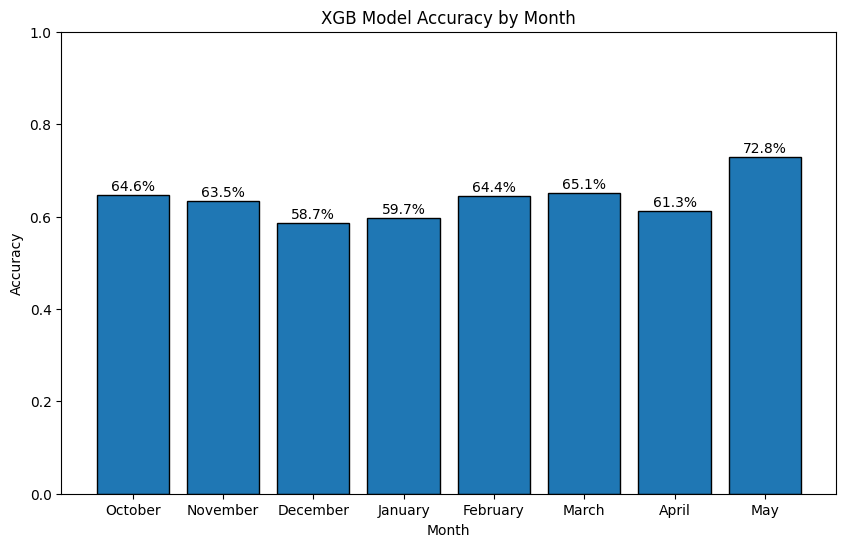

In [ ]:
# Get predictions
y_pred = best_xgb.predict(X_test)

# Create a table to compare results
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred
results['Date'] = df_final.loc[y_test.index, 'GAME_DATE_EST']
results['Month'] = results['Date'].dt.month_name()

# This creates a column of True (1) and False (0)
results['is_correct'] = (results['Actual'] == results['Predicted'])

# Calculate the average correct guess rate per month
monthly_accuracy = results.groupby('Month')['is_correct'].mean()

# Sort the months correctly
order = ['October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June']
monthly_accuracy = monthly_accuracy.reindex(order).dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_accuracy.index, monthly_accuracy.values, edgecolor='black')

# Loop to add numbers
for i in range(len(monthly_accuracy)):
    value = monthly_accuracy.values[i]
    plt.text(i, value + 0.01, f"{value:.1%}", ha='center')

plt.title('XGB Model Accuracy by Month')
plt.ylabel('Accuracy')
plt.xlabel('Month')
plt.ylim(0, 1.0)
plt.show()

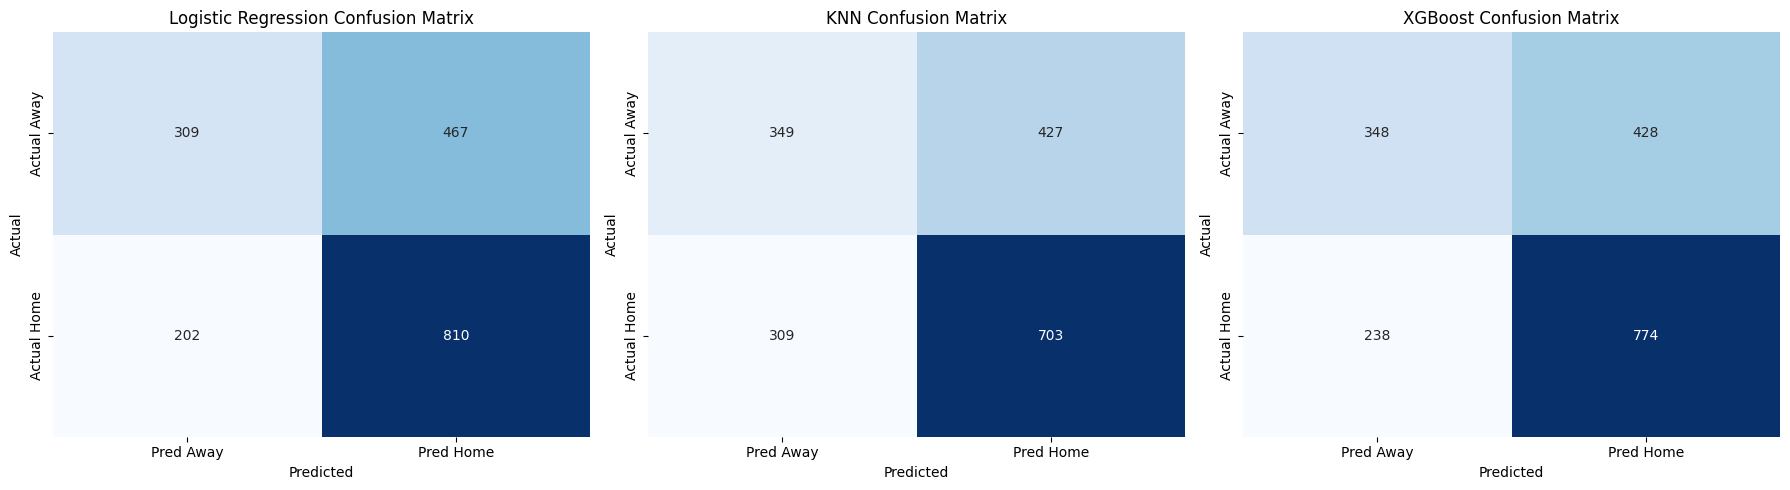

In [ ]:
# Confusion Matrices
# Define the models and their predictions
models = {
    'Logistic Regression': best_lr,
    'KNN': best_knn,
    'XGBoost': best_xgb
}

# Set dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    # Get predictions
    if name == 'XGBoost':
        preds = model.predict(X_test)
    else:
        # Assumes X_test_scaled is already defined from previous steps
        preds = model.predict(X_test_scaled)

    # Generate matrix
    cm = confusion_matrix(y_test, preds)

    # Plot Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=['Pred Away', 'Pred Home'],
                yticklabels=['Actual Away', 'Actual Home'])

    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2987632403.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rest_Status', y='HOME_TEAM_WINS', data=group_data,


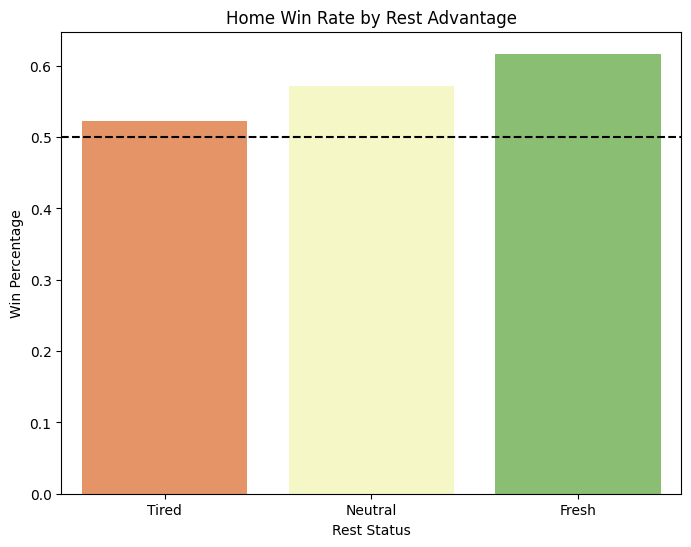

In [ ]:
# Def func
def check_rest(diff):
    if diff <= -2:
        return "Tired"
    elif diff >= 2:
        return "Fresh"
    else:
        return "Neutral"

# Use func
df_model['Rest_Status'] = df_model['Diff_Rest_Days'].apply(check_rest)

# Calculate WR
group_data = df_model.groupby('Rest_Status')['HOME_TEAM_WINS'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))

# Set order
sns.barplot(x='Rest_Status', y='HOME_TEAM_WINS', data=group_data,
            order=['Tired', 'Neutral', 'Fresh'], palette='RdYlGn')

# Add 50% line
plt.axhline(0.5, color='black', linestyle='--')

plt.title('Home Win Rate by Rest Advantage')
plt.ylabel('Win Percentage')
plt.xlabel('Rest Status')
plt.show()

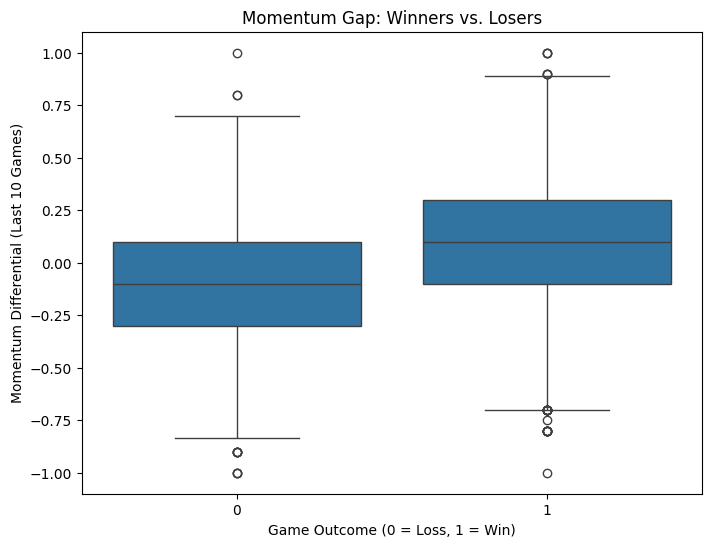

In [ ]:
# Plot
plt.figure(figsize=(8, 6))

# Boxplot
sns.boxplot(x='HOME_TEAM_WINS', y='Diff_Last_10', data=df_model)

plt.title('Momentum Gap: Winners vs. Losers')
plt.xlabel('Game Outcome (0 = Loss, 1 = Win)')
plt.ylabel('Momentum Differential (Last 10 Games)')
plt.show()

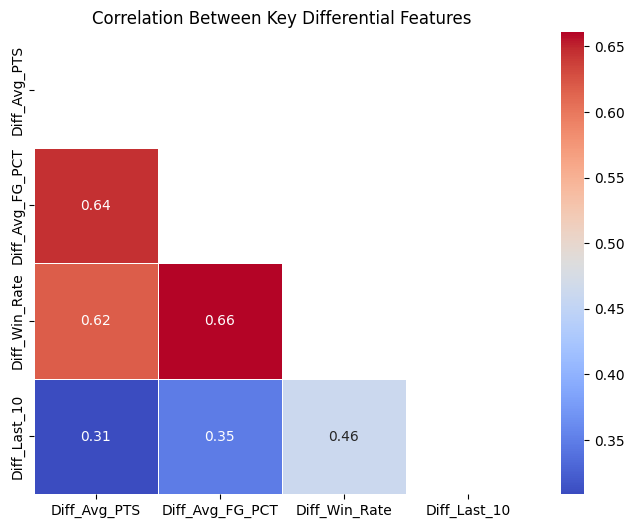

In [ ]:
# Select top features
features_to_check = ['Diff_Avg_PTS', 'Diff_Avg_FG_PCT', 'Diff_Win_Rate', 'Diff_Last_10']
corr_matrix = df_model[features_to_check].corr()

# Get only half the map
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot
plt.figure(figsize=(8, 6))

# use mask=mask to hide the top half
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

plt.title('Correlation Between Key Differential Features')
plt.show()